# How ANOVA works

To compare systemic to unsystemic variance - By using different means for different groups, can we make a better predictive model?

Repeating t-tests between a bunch of groups would inflate type I error rate

## Getting results


# Performing ANOVA

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
data = pd.read_csv('./Viagra.dat', delim_whitespace=True)
data.head()

,person,dose,libido
0,1,1,3
1,2,1,2
2,3,1,1
3,4,1,1
4,5,1,4


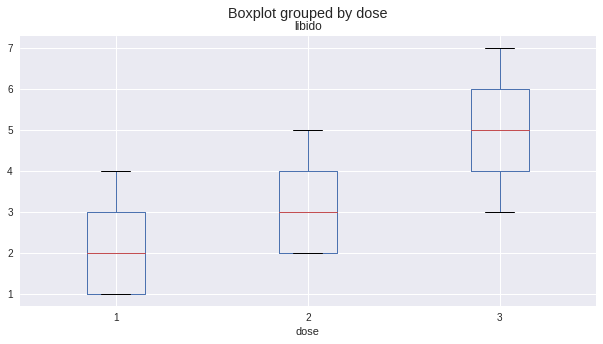

In [12]:
plt.clf()
data.boxplot('libido', by='dose', figsize=(10,5))
plt.show()

### With Scipy

In [39]:
from scipy import stats

# test = data.query('dose==3')
# test.libido
g1 = data.query('dose==1')
g2 = data.query('dose==2')
g3 = data.query('dose==3')

f, p = stats.f_oneway(g1.libido, g2.libido, g3.libido)
print('F-ratio: ', f)
print('p-value: ', p)

F-ratio:  5.1186440678
p-value:  0.0246942895382


##### With Regression
- Create dummy variables for different groups
- prediction  = b0 + b1*g1 + b2*g2
- b0 is the mean of the base category
- b1 is the difference in means of the 1st group to the base, etc...
    - Like a regression, kinda

### With Statsmodels

In [75]:
import statsmodels as sm
from statsmodels.formula.api import ols

dummies = pd.get_dummies(data.dose, prefix='dummy')
data_dummies = pd.concat([data.drop('dose', axis=1), dummies.drop('dummy_1', axis=1)], axis=1)

formula = ('libido ~ dummy_2 + dummy_3')
res = ols(formula, data=data_dummies).fit()
res.summary()

/home/shlapo/.anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 libido   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 29 Sep 2017   Prob (F-statistic):             0.0247
Time:                        10:48:57   Log-Likelihood:                -24.683
No. Observations:                  15   AIC:                             55.37
Df Residuals:                      12   BIC:                             57.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2000      0.627      3.508      0.004       0.834       3.566
dummy_2        1.0000      0.887      1.127      0.282      -0.932       2.932
dummy_3        2.8000      0.887      3.157      0.008       0.868       4.732
==============================================================================
Omnibus:                        2.517   Durbin-Watson:                   2.408
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                1.108
Skew:                           0.195   Prob(JB):                        0.575
Kurtosis:                       1.727   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Calculations
- SSt = diff between each point and grand mean / variance*(points - 1)
- SSr = diff between each point and it's group mean
    - how much of the variation can't be explained by the model
    - calculated by group and summed - diff between each point and it's group
    - degrees of freedom is dft - dfm
- SSm = diff between mean group values and grand mean
    - how much data can be explained by the fact that they come from different groups

SS values are influenced by the number of things they sum, so need to divide them by the df

F-ratio is the ratio of the mean SSm/mean SSr, so you want the model to explain more than the unexplained variance: F > 1

### By Hand

In [15]:
n = len(data.libido)
n1, n2, n3 = data.groupby('dose').count().person
k = len(pd.unique(data.dose))

# Calculate total and group means
mean = data.libido.mean()
g1_mean, g2_mean, g3_mean = data.groupby('dose').mean().libido 

# Calculate group variances
g1_var, g2_var, g3_var = data.groupby('dose').var().libido

# Calculate Sum of Squares values
SSt = data.libido.var()*(n-1)
SSm = n1*(g1_mean - mean)**2 + n2*(g2_mean - mean)**2 + n3*(g3_mean - mean)**2
SSr = (n1-1)*g1_var + (n2-1)*g2_var + (n3-1)*g3_var


print('SS total: ', SSt)
print('SS model: ', SSm)
print('SS residual: ', SSr)

SS total:  43.73333333333333
SS model:  20.1333333333
SS residual:  23.6


In [16]:
# Calculate mean squares

MSm = SSm/(k-1)
MSr = SSr/((n-1)-(k-1))

F = MSm/MSr
p = stats.f.sf(F, (k-1), ((n-1) - (k-1)))

print('F-ratio: ', F)
print('p-value: ', p)

F-ratio:  5.1186440678
p-value:  0.0246942895382


#### Assumptions
Homogeneity of variance (variance of different groups are equal) - can be tested with Levene's test
Becomes less robust when sample sizes are not equal

#### Questions
Does all the data need to be normal, or do each of the groups need to be normally distributed? 

##### Past the F-ratio
We want to know where differences in groups lie.

We can either:
1. Break down variance accounted for by model into component parts
2. Compare every group w/ stricter acceptance (to avoid Type I error) - post hoc tests

Difference is like 1 vs 2-tailed test. 
- Planned comparison when you have specific hypothesis to test
- post hoc tests when there's no specific hypothesis

##### Planned Contrasts
- Need to have your hypothesis before you go collect the data.
- Split up variance due to model into more components
- Each contrast can only compare to chunks of variation
- Once you compare a group in one contrast you can't use it again.
    - Should always be k-1 contrasts
- Intercepts again represent difference between the means of groups, divided by number of groups in contrast



In [71]:
# Create contrasts

data['contrast_1'] = data.dose.apply(lambda x: -2 if x==1 else 1)
data['contrast_2'] = data.dose.apply(lambda x: 0 if x==1 else (-1 if x==2 else 1))

formula = ('libido ~ contrast_1 + contrast_2')
res = ols(formula, data=data).fit()
res.summary()

/home/shlapo/.anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 libido   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 29 Sep 2017   Prob (F-statistic):             0.0247
Time:                        09:48:42   Log-Likelihood:                -24.683
No. Observations:                  15   AIC:                             55.37
Df Residuals:                      12   BIC:                             57.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4667      0.362      9.574      0.000       2.678       4.256
contrast_1     0.6333      0.256      2.474      0.029       0.075       1.191
contrast_2     0.9000      0.443      2.029      0.065      -0.066       1.866
==============================================================================
Omnibus:                        2.517   Durbin-Watson:                   2.408
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                1.108
Skew:                           0.195   Prob(JB):                        0.575
Kurtosis:                       1.727   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Experimental groups were significantly different from control ( contrast_1) but not significantly different from each other (contrast_2).

#### Other Contrast Codings
So I guess you can break the orthogonal rule, as long as you consider that the comparisons are now dependant.

Polynomial, Quadratic, etc...

Check out patsy package for coding matrices.

### Post hoc
If you have no preconcieved hypotheses, do a full pairwise comparison.

Bonferroni correction - you need to divide p by k (number of tests)
- Increase probability of Type II error

More sophisticated methods are *stepped*
- start with Bonferroni, then modify the significance for each consecutive test

If a test is too conservative (really wants to avoid Type I), it won't have much statistical power (so it'll reject meaningful differences - Type II)

#### Different Tests
- Equal sample sizes -> Tukey
- Bonferroni is conservative, but controls Type I
- Holm's power > Bonferroni
- Benjamini-Hochberg > Holm (but it controls False Discovery Rate)

In [80]:
pairwise = sm.stats.multicomp.pairwise_tukeyhsd(data.libido, data.dose)
pairwise.summary()

group1,group2,meandiff,lower,upper,reject
1,2,1.0,-1.3651,3.3651,False
1,3,2.8,0.4349,5.1651,True
2,3,1.8,-0.5651,4.1651,False
